In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
from pysquid.rnet import ResistorNetworkModel
from pysquid.model import FluxModelTVPrior
from pysquid.linearModel import *
from pysquid.kernels.magpsf import GaussianKernel
from pysquid.util.helpers import *
from pysquid.tests.admmTests import LinearModelTV_ADMM_NoFFT

In [3]:
pdict = {'psf_params': np.array([1., 2., 2.]), 'sigma': np.array([.0005])}
gshape = np.array([14, 14])
Ly_pad, Lx_pad = gshape
padding = np.array([2,2])
py, px = padding
phishape = gshape - 2*padding
Ly, Lx = phishape

In [4]:
myg = np.zeros(phishape)
myg[4:-4, 4:-4] = 1.
#myg[23:-23,23:-23] = 1.
myg_pad = np.zeros(gshape)
myg_pad[py:py+Ly, px:px+Lx] = myg
mykernel = GaussianKernel(myg.shape, pdict['psf_params'], _fftw_flags=['FFTW_MEASURE'], cutoff=True)
phi = mykernel.applyM(myg).real
phi_noise = phi + pdict['sigma']*np.random.randn(*myg.shape)

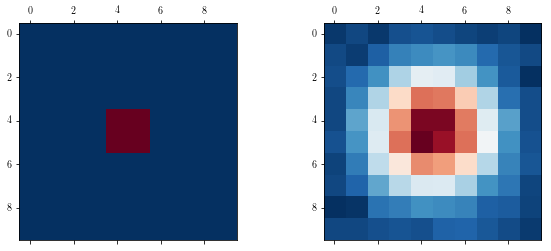

In [5]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))

axes[0].matshow(myg)
axes[1].matshow(phi_noise)

In [6]:
mu_reg = 20

In [7]:
model = FluxModelTVPrior(phi_noise, pdict, mu_reg = mu_reg, padding = padding,)
print("True data NLL = {}".format(model.computeNLL(myg_pad.ravel(), ['gfieldflat'])))

True data NLL = -350.055496797


In [8]:
from pysquid.infercurrents.deconvolve import TVDeconvolver

In [9]:
def testNLL(gfield, phi):
    mphi = model.kernel.applyM(gfield.reshape(model.Ly_pad,-1)).real
    res = phi.ravel() - mphi.ravel()
    return res.dot(res)/2*model.sigma**2, admm.mu_reg*admm.TV(gfield).sum()

def showNLLComponents(gfield, phi):
    fid, tv = testNLL(gfield, phi)
    print("Fidelity contribution = {}, TV contribution = {}".format(fid, tv))

In [163]:
lmod = LinearModelTV_ADMM
#lmod = LinearModelTV_ADMM_NoFFT
admm = lmod(model, rho = 1E-2, mu_reg = mu_reg)
admm_fft = LinearModelTV_ADMM(model, rho = 1E-2, mu_reg = mu_reg)
admm.sigma = model.sigma

In [164]:
startg = myg_pad.ravel() + 1E-1*np.random.randn(model.N_pad)
showNLLComponents(startg, phi_noise)
nll0 = admm.computeNLL(phi_noise.ravel(), startg)

gmin = admm.solve(phi_noise.ravel(), startg,
                  itnlim = 40, iprint = 20, eps_abs = 1E-16, eps_rel=1E-16)

nll1 = admm.computeNLL(phi_noise.ravel(), gmin)
print("DeltaNLL = {}".format(nll1 - nll0))
showNLLComponents(gmin, phi_noise)

Fidelity contribution = 2.06608471093e-11, TV contribution = 809.345949356
Initial NLL = 471.723110472
	Itn 0: NLL = 3.384410e+02, r = 1.691e-02,  s = 2.255e-07, eps_p = 4.283e-15, eps_d = 1.000e-15
	Itn 1: NLL = 2.906224e+02, r = 5.554e-08,  s = 2.071e-07, eps_p = 4.270e-15, eps_d = 1.000e-15
	Itn 2: NLL = 2.303620e+02, r = 6.962e-08,  s = 1.584e-07, eps_p = 4.264e-15, eps_d = 1.000e-15
	Itn 3: NLL = 2.211533e+02, r = 1.031e-09,  s = 1.551e-07, eps_p = 4.257e-15, eps_d = 1.000e-15
		Restarted 1.85188647135e-06 > 0.999 * 1.14377704046e-06
	Itn 4: NLL = 2.136435e+02, r = 6.704e-10,  s = 1.542e-07, eps_p = 4.245e-15, eps_d = 1.000e-15
		Restarted 3.34065600797e-06 > 0.999 * 1.14492196242e-06
	Itn 5: NLL = 2.110379e+02, r = 4.886e-09,  s = 1.537e-07, eps_p = 4.240e-15, eps_d = 1.000e-15
		Restarted 5.69297915909e-06 > 0.999 * 1.14606803045e-06
	Itn 6: NLL = 1.974196e+02, r = 3.500e-08,  s = 1.525e-07, eps_p = 4.212e-15, eps_d = 1.000e-15
		Restarted 5.578352626e-06 > 0.999 * 1.1472152457e

In [165]:
decon = TVDeconvolver(mykernel, admm.mu)

In [166]:
gsol0 = decon.deconvolve(phi_noise.ravel(), startg, iprint = 2, itnlim = 40, eps_abs = 1E-16, eps_rel=1E-16)

Initial cost = 4.873164e-04
	Itn 0: cost = 4.528449e-04, r = 1.691e-02, s = 2.255e-07 rho = 0.01
	Itn 1: cost = 4.496850e-04, r = 4.236e-03, s = 2.179e-07 rho = 0.02
	Itn 2: cost = 4.470970e-04, r = 1.060e-03, s = 2.113e-07 rho = 0.04
	Itn 3: cost = 4.454235e-04, r = 2.651e-04, s = 2.074e-07 rho = 0.08
	Itn 4: cost = 4.445583e-04, r = 6.629e-05, s = 2.056e-07 rho = 0.16
	Itn 5: cost = 4.441669e-04, r = 1.657e-05, s = 2.050e-07 rho = 0.32
	Itn 6: cost = 4.439969e-04, r = 4.144e-06, s = 2.049e-07 rho = 0.64
	Itn 7: cost = 4.439216e-04, r = 1.036e-06, s = 2.048e-07 rho = 1.28
	Itn 8: cost = 4.439216e-04, r = 1.036e-06, s = 2.048e-07 rho = 1.28
	Itn 9: cost = 4.439216e-04, r = 1.036e-06, s = 2.048e-07 rho = 1.28
	Itn 10: cost = 4.439216e-04, r = 1.036e-06, s = 2.048e-07 rho = 1.28
	Itn 11: cost = 4.439216e-04, r = 1.036e-06, s = 2.048e-07 rho = 1.28
	Itn 12: cost = 4.439216e-04, r = 1.036e-06, s = 2.048e-07 rho = 1.28
	Itn 13: cost = 4.439216e-04, r = 1.036e-06, s = 2.048e-07 rho = 1.28
	I

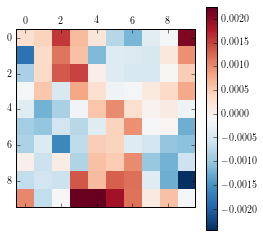

In [167]:
plt.matshow(decon.M.dot(gsol0).reshape(10,10)-phi_noise);plt.colorbar()

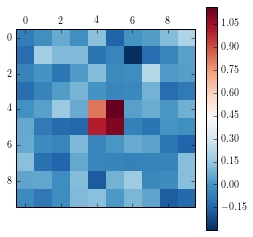

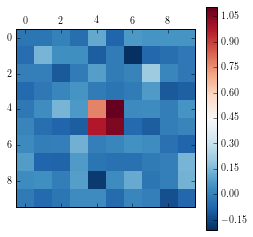

In [168]:
plt.matshow(gsol0.reshape(10,10));plt.colorbar()
plt.matshow(gmin.reshape(10,10));plt.colorbar()

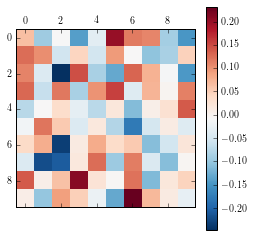

In [157]:
gdif = (gsol0.reshape(model.Ly_pad,-1)-myg)
plt.matshow(gdif);plt.colorbar()

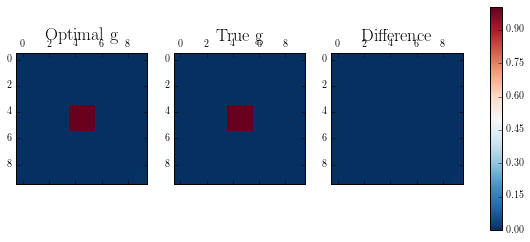

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
gmin_sq = gmin.reshape(model.Ly_pad,-1)
minl = 0# min(gmin.min(), myg_pad.min())
maxl = max(gmin.max(), myg_pad.max())
im = axes[0].matshow(gmin_sq,vmin=minl, vmax=maxl)
axes[0].set_title('Optimal g', fontsize=18)
im = axes[1].matshow(myg_pad,vmin=minl, vmax=maxl)
axes[1].set_title('True g', fontsize=18)
im = axes[2].matshow(gmin_sq - myg_pad, vmin=minl, vmax=maxl)
axes[2].set_title('Difference', fontsize=18)
cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, **kw)

0.17225633046331371

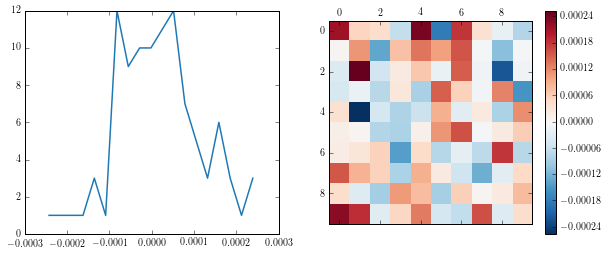

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
res = model.residuals
hist, bins = np.histogram(res, bins=19)
axes[0].plot(0.5*(bins[1:]+bins[:-1]), hist, '-')
im = axes[1].matshow(res.reshape(model.Ly,-1))
cax, kw = mpl.colorbar.make_axes(axes[1])
plt.colorbar(im, cax = cax, **kw)
np.mean(res)/model.sigma

In [10]:
from pysquid.tests.kernelTests import testConvolution, testTranspose

In [12]:
err, kertest, Mtest = testConvolution(GaussianKernel, psf_params = pdict['psf_params'], shape = model._shape, 
                padding = model._padding)

In [17]:
print(np.sum(kertest.crop(kertest.MPSF_k*kertest.MPSF_k.conj())))
print((Mtest.T.dot(Mtest)).trace())

(0.0127572104538+0j)
0.0350084103009


In [20]:
mtmfft = np.sum(kertest.crop(kertest.MPSF_k*kertest.MPSF_k.conj())).real
mtm = (Mtest.T.dot(Mtest)).trace()

In [27]:
s, u = np.linalg.eigh(Mtest.T.dot(Mtest))

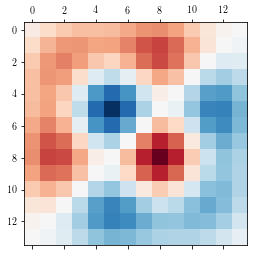

In [39]:
plt.matshow(u[:,-10].reshape(kertest._padshape))

In [62]:
Cmask = np.zeros_like(kertest.MPSF_k)
Cmask[kertest.py:kertest.py+kertest.Ly,
      kertest.px:kertest.px+kertest.Lx] = 1.

In [70]:
np.sum(np.abs(kertest.MPSF_k.conj()*kertest.fftw.fft(Cmask*kertest.fftw.ifft(kertest.MPSF_k))).reshape(*kertest.MPSF_k.shape))

0.022573469065126875

In [78]:
np.polyfit(np.arange(len(s))[-25:], np.log(s[-25:]), 1)

array([  0.28838813, -60.92148904])

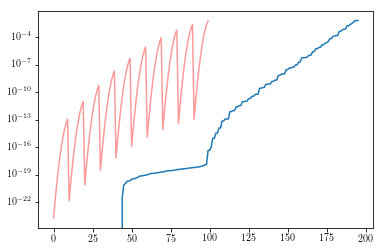

In [47]:
plt.plot(s);plt.yscale('log')
plt.plot((kertest.crop(kertest.MPSF_k*kertest.MPSF_k.conj())).real.ravel()[::-1])

In [41]:
testTranspose(GaussianKernel, psf_params = pdict['psf_params'], shape = model._shape, 
                padding = model._padding)

(5.7530182462558143e-18, 4.5845094111665373e-18)

In [99]:
Ly, Lx = model._shape
py, px = model._padding
foo = np.zeros((2*(Ly+2*py), 2*(Lx+2*px)))
foo[py:Ly+py, px:Lx+px] = np.ones((Ly, Lx))

In [111]:
gg = np.random.randn(model.N_pad).reshape(*model._padshape)

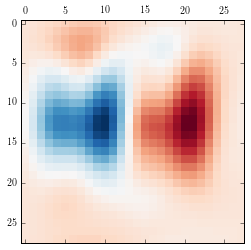

In [128]:
bar = np.fft.ifftn(np.fft.fftn(foo)*model.kernel.MPSF_k * np.fft.fftn(gg, s=model.kernel.fftw.shape)).real
plt.matshow(bar)

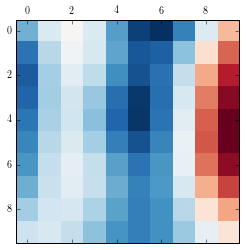

In [126]:
plt.matshow(model.kernel.applyM(gg).real)

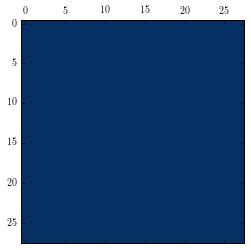

In [116]:
plt.matshow(model.kernel._padFlux)

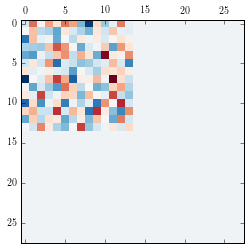

In [122]:
plt.matshow(np.fft.ifftn(np.fft.fftn(gg, s=model.kernel.fftw.shape)).real)